<a href="https://colab.research.google.com/github/Jorgesff/Tech_challenge_3/blob/main/FineTuning_FIAP_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###PIPELINE DE LIMPEZA DE DADOS

In [ ]:
# ==================== IMPORTS ====================
import pandas as pd
import numpy as np
import html
import re
import json
from pathlib import Path
from tqdm.notebook import tqdm
import logging
from google.colab import drive

# ==================== CONFIGURAÇÃO DE LOG ====================
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ==================== MONTAR DRIVE ====================
drive.mount('/content/drive')

# Diretório base dentro do seu Drive
BASE_DIR = Path("/content/drive/MyDrive/tc_fiap_ft")
BASE_DIR.mkdir(parents=True, exist_ok=True)

# Caminhos dos arquivos
INPUT_FILE = BASE_DIR / "trn.json"          # arquivo original que você subiu
OUTPUT_FILE = BASE_DIR / "base_limpa.json"  # base limpa final
CHUNKS_DIR = BASE_DIR / "chunks"            # pasta para chunks
CHUNKS_DIR.mkdir(parents=True, exist_ok=True)

# ==================== FUNÇÕES ====================

def clean_text(cell):
    """
    Limpa texto mantendo acentos portugueses, remove HTML, múltiplos espaços,
    emojis e caracteres especiais.
    """
    if isinstance(cell, (list, tuple)):
        cell = " ".join(map(str, cell))
    if cell is None or (isinstance(cell, float) and np.isnan(cell)):
        return ""
    cell = str(cell)
    cell = html.unescape(cell)  # Corrige entidades HTML
    cell = re.sub(r'\s+', ' ', cell)  # Remove múltiplos espaços
    # Mantém letras, números e acentos portugueses, remove emojis e caracteres especiais
    cell = re.sub(r'[^\w\s\u00C0-\u017F.,;:!?()-]', '', cell)
    return cell.strip()

def load_and_clean_data(json_file_path):
    """
    Carrega e limpa o dataset JSONL:
    - Remove colunas desnecessárias (UIDs, target_ind, target_rel)
    - Limpa texto
    - Filtra dados válidos
    - Remove duplicados
    - Retorna df limpo + imprime comparativo de linhas antes/depois
    """
    if not json_file_path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {json_file_path}")

    df = pd.read_json(json_file_path, lines=True, dtype=False)
    linhas_antes = len(df)

    # Remove colunas irrelevantes
    cols_to_remove = ['target_ind', 'target_rel', 'uid']
    df = df.drop(columns=[c for c in cols_to_remove if c in df.columns])

    # Limpa todas as colunas de texto
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(clean_text)

    # Filtra linhas válidas e remove duplicados
    df = df[(df['title'].notna()) & (df['content'].notna())]
    df = df[(df['title'] != "") & (df['content'] != "")]
    df = df.drop_duplicates(subset=['title', 'content']).reset_index(drop=True)

    linhas_depois = len(df)

    # Comparativo de linhas na tela
    print(f"Linhas originais: {linhas_antes}")
    print(f"Linhas após limpeza: {linhas_depois}")
    print(f"Linhas removidas: {linhas_antes - linhas_depois} ({100*(linhas_antes - linhas_depois)/linhas_antes:.2f}%)\n")

    logger.info(f"Linhas originais: {linhas_antes}")
    logger.info(f"Linhas após limpeza: {linhas_depois}")
    logger.info(f"Removidas: {linhas_antes - linhas_depois} linhas ({100*(linhas_antes - linhas_depois)/linhas_antes:.2f}%)")

    return df

def save_clean_data(df, output_file):
    """Salva DataFrame limpo em formato JSONL dentro do Drive."""
    df.to_json(output_file, orient='records', lines=True, force_ascii=False)
    logger.info(f"Base limpa salva em: {output_file}")

def create_chunks(df, chunk_size=300000):
    """
    Divide o dataset em chunks menores para facilitar o fine-tuning
    e economizar memória/GPU.
    """
    logger.info(f"Dividindo dataset em chunks de {chunk_size} linhas...")
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i+chunk_size]
        chunk_file = CHUNKS_DIR / f'base_chunk_{i//chunk_size + 1}.jsonl'
        chunk.to_json(chunk_file, orient='records', lines=True, force_ascii=False)
    logger.info(f"Chunks criados em: {CHUNKS_DIR}")

# ==================== EXECUÇÃO ====================
# 1️⃣ Carrega e limpa os dados
df_clean = load_and_clean_data(INPUT_FILE)

# 2️⃣ Salva a base limpa completa
save_clean_data(df_clean, OUTPUT_FILE)

# 3️⃣ Cria chunks de 300k linhas
create_chunks(df_clean, chunk_size=300000)




Mounted at /content/drive
Linhas originais: 2248619
Linhas após limpeza: 1366541
Linhas removidas: 882078 (39.23%)



# ==================== INSPEÇÃO DOS CHUNKS ====================

In [ ]:
# Função para detectar caracteres não permitidos
def has_invalid_chars(text):
    if not isinstance(text, str):
        return True
    return bool(re.search(r'[^\w\s\u00C0-\u017F.,;:!?()-]', text))

# Lista todos os chunks criados
chunk_files = sorted(CHUNKS_DIR.glob("base_chunk_*.jsonl"))
print(f"\nTotal de chunks criados: {len(chunk_files)}")

# Mostra primeiras 5 linhas de cada chunk e valida limpeza
for i, chunk_file in enumerate(chunk_files, start=1):
    print(f"\n=== Chunk {i}: {chunk_file.name} ===")
    df_chunk = pd.read_json(chunk_file, lines=True)
    display(df_chunk.head(5))

    empty_titles = df_chunk['title'].isna().sum() + (df_chunk['title'] == "").sum()
    empty_contents = df_chunk['content'].isna().sum() + (df_chunk['content'] == "").sum()
    invalid_titles = df_chunk['title'].apply(has_invalid_chars).sum()
    invalid_contents = df_chunk['content'].apply(has_invalid_chars).sum()

    print(f"Total de linhas no chunk: {len(df_chunk)}")
    print(f"Linhas com 'title' vazio: {empty_titles}")
    print(f"Linhas com 'content' vazio: {empty_contents}")
    print(f"Linhas com caracteres inválidos em 'title': {invalid_titles}")
    print(f"Linhas com caracteres inválidos em 'content': {invalid_contents}")


Total de chunks criados: 5

=== Chunk 1: base_chunk_1.jsonl ===


,title,content
0,Girls Ballet Tutu Neon Pink,High quality 3 layer ballet tutu. 12 inches in...
1,Mogs Kittens,Judith Kerrs bestselling adventures of that en...
2,Girls Ballet Tutu Neon Blue,Dance tutu for girls ages 2-8 years. Perfect f...
3,The Prophet,"In a distant, timeless place, a mysterious pro..."
4,Rightly Dividing the Word,--This text refers to thePaperbackedition.


Total de linhas no chunk: 300000
Linhas com 'title' vazio: 0
Linhas com 'content' vazio: 0
Linhas com caracteres inválidos em 'title': 0
Linhas com caracteres inválidos em 'content': 0

=== Chunk 2: base_chunk_2.jsonl ===


,title,content
0,Bunny Rabbit in the Sunlight,"Simple paper collages, each captioned with a s..."
1,Good Fish: Sustainable Seafood Recipes from th...,Becky Selengut is one of the people who will s...
2,"GrassRoutes Oakland and Berkeley, Second Editi...","The founder of GrassRoutes Travel, Serena Bart..."
3,The Everyday Wok Cookbook: Simple and Satisfyi...,Dont make assumptions from the title. The Ever...
4,"Cass Turnbulls Guide to Pruning, 3rd Edition: ...","Finally, the book has arrived that demystifies..."


Total de linhas no chunk: 300000
Linhas com 'title' vazio: 0
Linhas com 'content' vazio: 0
Linhas com caracteres inválidos em 'title': 0
Linhas com caracteres inválidos em 'content': 0

=== Chunk 3: base_chunk_3.jsonl ===


,title,content
0,Reckitt Benckiser 6233800750 ZUD 16 Oz. Rust ...,"Removes rust from sinks, tubs, bathroom bowls...."
1,Pop-Open Light Duty Hamper Easy Carry Mesh Ham...,Easy carry handles. Opens in seconds. Built in...
2,Twinkling Christmas Tree Star Dog Holiday Swea...,Our innovative Casual Canine? Christmas Tree S...
3,Whink Steam Iron Cleaner,Removes clogging scale from steam and spray ir...
4,Habitrail Ovo Pet Habitat,The Habitrail OVO Elbow allows you to give rou...


Total de linhas no chunk: 300000
Linhas com 'title' vazio: 0
Linhas com 'content' vazio: 0
Linhas com caracteres inválidos em 'title': 0
Linhas com caracteres inválidos em 'content': 0

=== Chunk 4: base_chunk_4.jsonl ===


,title,content
0,Contigo Autoseal Bella Double Wall Insulated 1...,Never spill another drop. 100-Percent spill- a...
1,Uber Bar Tools Projig CAN Multi Measure Jigger,Uber Bar Tools - Projig (Canadian) The first d...
2,"Tovolo Small 2.5-Quart Melamine Colander, Blue",This Tovolo small colander features a durable ...
3,Kuhn Rikon Farmers Market Knife Colori 4-Inch ...,The Kuhn Rikon Farmers Market Paring Knife Col...
4,"Fashion Pet Pink and Green STRIPED PJS, Extra ...",Soft and cozy ribbed cotton fabric. Long sleev...


Total de linhas no chunk: 300000
Linhas com 'title' vazio: 0
Linhas com 'content' vazio: 0
Linhas com caracteres inválidos em 'title': 0
Linhas com caracteres inválidos em 'content': 0

=== Chunk 5: base_chunk_5.jsonl ===


,title,content
0,Realtree Camo Pantech Burst P9070 Rubberized H...,New generic Snap-on Case This snap-on case kee...
1,Creepy Owl Head Latex Mask,Weve discovered yet another universal truth a ...
2,"Mycotic Toenail Nippers 6, Double Action","Mycotic Podiatry Toenail Nippers, double actio..."
3,5 Pcs Children Safety Finger Pinch Cartoon Ani...,Applied to help prevent your children from acc...
4,MuchBuy 16.4 Feet 600 Leds 3528 SMD Flexible L...,Packaging Included: 1 X Strip


Total de linhas no chunk: 166541
Linhas com 'title' vazio: 0
Linhas com 'content' vazio: 0
Linhas com caracteres inválidos em 'title': 0
Linhas com caracteres inválidos em 'content': 0


INICIANDO FINE TUNING

In [ ]:
!pip install -U pandas==2.1.0
!pip install -U pyarrow==12.0.1
!pip install -q unsloth transformers accelerate datasets peft bitsandbytes trl pandas tqdm evaluate --quiet

  Using cached pandas-2.1.0.tar.gz (4.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached pyarrow-12.0.1.tar.gz (1.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/c5/68/d3410e975bebbf5be00c1238d0418345d8ec5d88b7a6c102211a1c967edd/pyarrow-12.0.1.tar.gz (f

==================== IMPORTS ====================

In [ ]:

import os, sys, time, html, re, json, torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from google.colab import drive
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import evaluate

# ==================== VERIFICAÇÃO DE AMBIENTE ====================
def check_environment():
    print("=== Verificação de ambiente ===")
    if not torch.cuda.is_available():
        raise SystemError("GPU não detectada. Vá em: Ambiente de execução → Alterar tipo de hardware → GPU.")
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU detectada: {gpu_name}")
    if "A100" not in gpu_name:
        print("Aviso: Recomendado uso da A100 para este modelo.")
    print(f"Versão PyTorch: {torch.__version__}")
    print("Ambiente verificado com sucesso.\n")

check_environment()

# ==================== CONFIGURAÇÃO DE DIRETÓRIOS ====================
drive.mount('/content/drive')
BASE_DIR = Path("/content/drive/MyDrive/tc_fiap_ft")
CHUNKS_DIR = BASE_DIR / "chunks"
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
LOGS_DIR = BASE_DIR / "logs"
OUTPUT_DIR = BASE_DIR / "ft_model_final"
RESULTS_DIR = BASE_DIR / "resultados"

for d in [CHUNKS_DIR, CHECKPOINT_DIR, LOGS_DIR, OUTPUT_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

LOG_FILE = LOGS_DIR / "training_log.csv"
pd.DataFrame(columns=["step","loss","elapsed_min","checkpoint","progress_%"]).to_csv(LOG_FILE, index=False)

# ==================== FUNÇÕES AUXILIARES ====================
def clean_text(cell):
    if isinstance(cell, (list, tuple)): cell = " ".join(map(str, cell))
    if cell is None or (isinstance(cell, float) and np.isnan(cell)): return ""
    cell = html.unescape(str(cell))
    cell = re.sub(r'\s+', ' ', cell)
    cell = re.sub(r'[^\w\s\u00C0-\u017F.,;:!?()-]', '', cell)
    return cell.strip()

def load_all_chunks(chunks_dir):
    dfs = []
    for f in sorted(chunks_dir.glob("base_chunk_*.jsonl")):
        df = pd.read_json(f, lines=True)
        for col in ['uid','target_ind','target_rel']:
            if col in df.columns: df.drop(columns=[col], inplace=True)
        df['title'] = df['title'].apply(clean_text)
        df['content'] = df['content'].apply(clean_text)
        df['text'] = (
            "### Instrução:\nDescreva o produto a seguir.\n"
            "### Entrada:\n" + df['title'] + "\n"
            "### Resposta:\n" + df['content']
        )
        dfs.append(df[['text']])
    df_full = pd.concat(dfs, ignore_index=True)
    print(f"Dataset final carregado: {len(df_full):,} linhas.")
    return df_full



=== Verificação de ambiente ===
GPU detectada: NVIDIA A100-SXM4-80GB
Versão PyTorch: 2.8.0+cu126
Ambiente verificado com sucesso.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# ==================== DADOS E TOKENIZAÇÃO ====================
df_full = load_all_chunks(CHUNKS_DIR)
dataset = Dataset.from_pandas(df_full)

model_name = "unsloth/llama-3-8b-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
max_length = 1024

def preprocess(example):
    enc = tokenizer(example["text"], truncation=True, padding="max_length", max_length=max_length)
    enc["labels"] = enc["input_ids"].copy()
    return enc

dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])

# ==================== MODELO COM LORA ====================
print("Carregando modelo base e aplicando configuração LoRA...")
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", load_in_4bit=True)

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_cfg)
print("Modelo LoRA configurado e pronto.\n")

# ==================== TREINAMENTO ====================
training_args = TrainingArguments(
    output_dir=str(CHECKPOINT_DIR),
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,           # aprendizado ajustado para convergir mais rápido
    fp16=True,
    logging_steps=50,
    save_strategy="steps",
    save_steps=200,
    num_train_epochs=1,
    max_steps=10000,
    save_total_limit=5,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer
)

print("Iniciando treinamento supervisionado...")
print("Estimativa de tempo: ~60 minutos na GPU A100 (3000 steps, 300k amostras)\n")



Dataset final carregado: 1,366,541 linhas.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Map:   0%|          | 0/1366541 [00:00<?, ? examples/s]

Carregando modelo base e aplicando configuração LoRA...


config.json: 0.00B [00:00, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

Modelo LoRA configurado e pronto.

Iniciando treinamento supervisionado...
Estimativa de tempo: ~60 minutos na GPU A100 (3000 steps, 300k amostras)



/tmp/ipython-input-305154959.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ==================== LOOP DE TREINAMENTO AJUSTADO ====================
start = time.time()
progress_bar = tqdm(total=training_args.max_steps, desc="Treinamento em progresso", ncols=120)
table_data = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

optimizer = trainer.create_optimizer()
lr_scheduler = trainer.create_scheduler(num_training_steps=training_args.max_steps, optimizer=optimizer)

for step, batch in enumerate(trainer.get_train_dataloader(), 1):
    batch = {k: v.to(device) for k, v in batch.items()}

    # Forward
    outputs = model(**batch)
    loss = outputs.loss

    # Gradient accumulation
    loss = loss / training_args.gradient_accumulation_steps
    loss.backward()

    if step % training_args.gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    # Logging a cada 50 steps
    if step % 50 == 0:
        elapsed = (time.time() - start) / 60
        ckpt = "Salvo" if step % 200 == 0 else "-"
        progress = round(step / training_args.max_steps * 100, 2)
        row = [step, float(loss.item()), round(elapsed,2), ckpt, f"{progress}%"]
        pd.DataFrame([row], columns=["step","loss","elapsed_min","checkpoint","progress_%"]).to_csv(LOG_FILE, mode='a', header=False, index=False)
        table_data.append(row)
        progress_bar.update(50)
        clear_output(wait=True)
        print("Últimas métricas registradas:")
        display(pd.DataFrame(table_data, columns=["Step","Loss","Min","Checkpoint","Progresso (%)"]).tail(5))

    # Salvar checkpoint a cada 200 steps
    if step % 200 == 0:
        trainer.save_model(CHECKPOINT_DIR / f"step_{step}")

    if step >= training_args.max_steps:
        break

progress_bar.close()

# ==================== FINALIZAÇÃO ====================
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

elapsed_total = (time.time() - start) / 60
print(f"Treinamento concluído em {elapsed_total:.2f} minutos.")
print(f"Modelo final salvo em: {OUTPUT_DIR}")
print(f"Logs detalhados: {LOG_FILE}")


Últimas métricas registradas:


,Step,Loss,Min,Checkpoint,Progresso (%)
55,2800,0.853833,15.47,Salvo,93.33%
56,2850,0.846016,15.76,-,95.0%
57,2900,0.905370,16.03,-,96.67%
58,2950,0.879874,16.30,-,98.33%
59,3000,0.744703,16.57,Salvo,100.0%


Treinamento em progresso: 100%|█████████████████████████████████████████████████████| 3000/3000 [16:35<00:00,  3.01it/s]


Treinamento concluído em 16.60 minutos.
Modelo final salvo em: /content/drive/MyDrive/tc_fiap_ft/ft_model_final
Logs detalhados: /content/drive/MyDrive/tc_fiap_ft/logs/training_log.csv



Gerando métricas pós-treinamento...
Menor loss: 0.2531 no step 400 (tempo: 2.19 min)


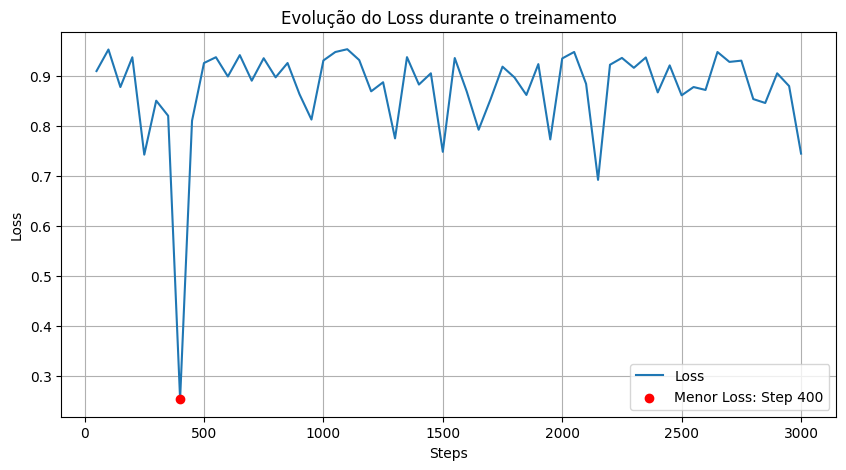

In [ ]:
# ==================== AVALIAÇÃO PÓS-TREINAMENTO ====================
print("\nGerando métricas pós-treinamento...")

# 1️⃣ Lê log de treinamento
df_log = pd.read_csv(LOG_FILE)



Menor loss: 0.2531 no step 400 (tempo: 2.19 min)


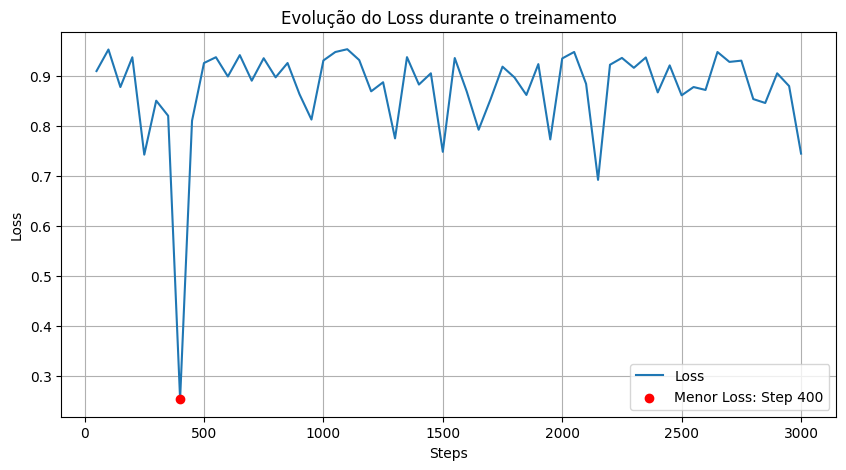

In [ ]:
# 2️⃣ Converte tempo decorrido em minutos
df_log["elapsed_min"] = df_log["elapsed_min"].astype(float)
# 3️⃣ Encontra o step com menor loss
min_loss_row = df_log.loc[df_log["loss"].idxmin()]
min_step = int(min_loss_row["step"])
min_loss = float(min_loss_row["loss"])
min_time = float(min_loss_row["elapsed_min"])
print(f"Menor loss: {min_loss:.4f} no step {min_step} (tempo: {min_time:.2f} min)")

# 4️⃣ Plota gráfico do loss vs step e tempo
plt.figure(figsize=(10,5))
plt.plot(df_log["step"], df_log["loss"], label="Loss")
plt.scatter(min_step, min_loss, color='red', zorder=5, label=f"Menor Loss: Step {min_step}")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evolução do Loss durante o treinamento")
plt.grid(True)
plt.legend()
plt.savefig(RESULTS_DIR / "grafico_loss.png")
plt.show()

In [ ]:
# 5️⃣ Calcula BLEU score (ajustado para df_full com 'text')
import evaluate
bleu = evaluate.load("bleu")

sample_eval = df_full.sample(200)  # 200 exemplos aleatórios

# Extraindo 'title' e 'content' do campo 'text'
def extract_title_content(text):
    try:
        title = text.split("### Entrada:\n")[1].split("\n### Resposta:")[0].strip()
        content = text.split("### Resposta:\n")[1].strip()
        return title, content
    except:
        return "", ""

titles, contents = zip(*sample_eval["text"].map(extract_title_content))

preds = ["Descreva o produto a seguir. " + t for t in titles]
refs = [[c] for c in contents]

bleu_score = bleu.compute(predictions=preds, references=refs)["bleu"]

# 6️⃣ Salva métricas em arquivo
elapsed_total = (time.time() - start) / 60
with open(RESULTS_DIR / "metricas.txt", "w") as f:
    f.write(f"BLEU Score: {bleu_score:.4f}\n")
    f.write(f"Tempo total: {elapsed_total:.2f} minutos\n")
    f.write

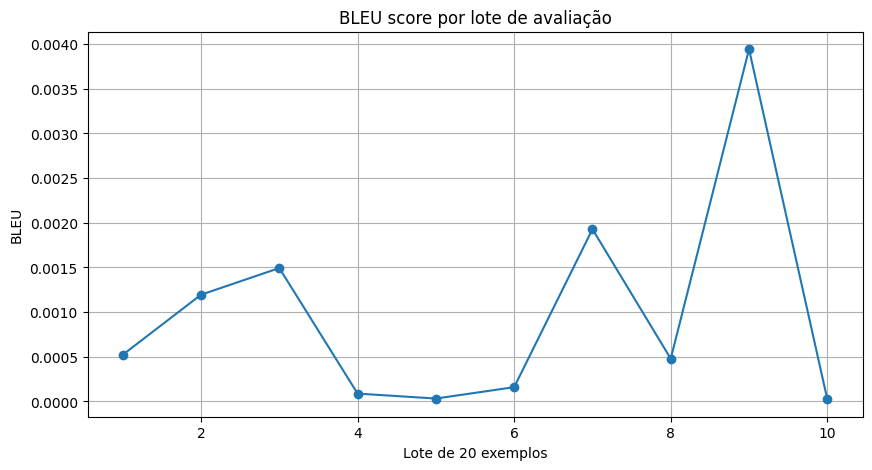


Métricas salvas em /content/drive/MyDrive/tc_fiap_ft/resultados


In [ ]:
# 5️⃣ Plota gráfico de BLEU acumulativo
batch_size = 20
bleu_batches = []
for i in range(0, len(preds), batch_size):
    batch_preds = preds[i:i+batch_size]
    batch_refs = refs[i:i+batch_size]
    batch_score = bleu.compute(predictions=batch_preds, references=batch_refs)["bleu"]
    bleu_batches.append(batch_score)

plt.figure(figsize=(10,5))
plt.plot(range(1, len(bleu_batches)+1), bleu_batches, marker='o')
plt.xlabel(f"Lote de {batch_size} exemplos")
plt.ylabel("BLEU")
plt.title("BLEU score por lote de avaliação")
plt.grid(True)
plt.savefig(RESULTS_DIR / "grafico_bleu.png")
plt.show()

# 6️⃣ Salva métricas em arquivo
elapsed_total = (time.time() - start) / 60
with open(RESULTS_DIR / "metricas.txt", "w") as f:
    f.write(f"BLEU Score: {bleu_score:.4f}\n")
    f.write(f"Tempo total: {elapsed_total:.2f} minutos\n")
    f.write(f"Menor loss: {min_loss:.4f} no step {min_step} (tempo: {min_time:.2f} min)\n")

print(f"\nMétricas salvas em {RESULTS_DIR}")

In [ ]:
# --------------------  Exemplos Qualitativos --------------------
print("\nExemplos de previsões vs resposta real (amostra de 5):\n")
for i, row in sample_eval.head(5).iterrows():
    entrada = row['text'].split("### Resposta:\n")[0].replace("### Instrução:\nDescreva o produto a seguir.\n### Entrada:\n", "")
    resposta_real = row['text'].split("### Resposta:\n")[1]
    previsto = "Descreva o produto a seguir. " + entrada
    display(Markdown(f"**Entrada:** {entrada}\n\n**Previsto:** {previsto}\n\n**Real:** {resposta_real}\n---"))


Exemplos de previsões vs resposta real (amostra de 5):



**Entrada:** The Winds of Darkover


**Previsto:** Descreva o produto a seguir. The Winds of Darkover


**Real:** The first hardcover edition of Bradleys 1977 novel.Copyright 1997 Reed Business Information, Inc.--This text refers to an out of print or unavailable edition of this title.
---

**Entrada:** Geyser (GA9-B) Brushed Nickel Garbage Disposal Air Switch Unit Brand NEW


**Previsto:** Descreva o produto a seguir. Geyser (GA9-B) Brushed Nickel Garbage Disposal Air Switch Unit Brand NEW


**Real:** Garbage Disposal Air Switch Unit This air switch is a great alternative to the wall switch.Easy top mount installation, no wiring required! Activate and deactivate by pushing the decorative air button. Compatible with all garbage disposals and built to last! Features: Air Activated Solid Construction Round style push button Mounts on to sink or counter top Brushed Nickel Finish Technical Information: 36-inch power cord125V-15Amp 1-38-inch hole needed for installation 6-Feet Air Hose
---

**Entrada:** Grip Coach Training Grips Mens


**Previsto:** Descreva o produto a seguir. Grip Coach Training Grips Mens


**Real:** Grip Coach Training Grip...Simple, Effective, Easy To Use! A good grip is the foundation of a good swing, and the Grip Coach is an invaluable aid in learning a proper grip. Lisa Ann Horst, LPGA- Class A Pro Grip Coach Training Grips feature: Transfers to any club in seconds Excellent training aid allows you to use your own club Helps beginners and experienced golfers improve technique for lower scores Available in right- and left-hand models Click here for installation steps and more info Models: Junior A Ladies A Mens Good Golf Begins With A Good Grip!
---

**Entrada:** Emerg Alert Medical Alert Emergency ID Bracelet and Wallet Card - Diabetic


**Previsto:** Descreva o produto a seguir. Emerg Alert Medical Alert Emergency ID Bracelet and Wallet Card - Diabetic


**Real:** The Diabetic Bracelet and Wallet Card provide two ways to alert others to your specific medical requirements. The Diabetic Bracelet provides quick on-body location, and the Wallet Card located in wallet or purse provides detailed information.
---

**Entrada:** Lineco Document Cleaning Pad


**Previsto:** Descreva o produto a seguir. Lineco Document Cleaning Pad


**Real:** Pads contain super soft grit free powder which absorbs and cleans surface dirt. Pad is lightly twisted over the item to be cleaned producing a thin layer of white powder, then gently rubbed over the area causing dust and dirt to be absorbed by the layer of powder. After cleaning, residue is simply brushed away.
---